---
title: "Lab Project AYA"
author: "Safia safa-tahar-henni"
date: "January 28, 2019"

---

# AYA Project

Les donnees proviennent de plusieurs sources:
* Leucegene:
500 patients dont 80 AYA
donnees:  p-value analyse expression differentielle
non normalise 
analyse avec DeSeq2
* TGCA: ~ 200 adultes
* Target (https://ocg.cancer.gov/programs/target/projects/acute-myeloid-leukemia):
Les chercheurs de TARGET analysent les tumeurs de patients pediatriques, dont beaucoup ont fait une rechute, afin d'identifier des biomarqueurs en correlation avec de mauvais resultats cliniques et / ou de nouvelles approches therapeutiques pour traiter la LMA chez l'enfant. (200 patients)


But : Analyse expression differentielle, mettre en evidence des genes specifique aux Adolescents et jeunes Adultes (18-40 ans).



In [2]:
#if (!requireNamespace("BiocManager", quietly = TRUE))
#    install.packages("BiocManager")
#BiocManager::install("DESeq2", version = "3.8")
library("DESeq2")
#BiocManager::install("genefilter", version = "3.8")
library(genefilter)

In [3]:
library('plyr') #package pour table de comptage
library(magrittr)
library("varhandle")
#library(tidyr)


Attaching package: ‘plyr’

The following object is masked from ‘package:matrixStats’:

    count

The following object is masked from ‘package:IRanges’:

    desc

The following object is masked from ‘package:S4Vectors’:

    rename



## Repartition des echantillons selon leurs caracteristiques cliniques

In [4]:
data_API = read.csv("/home/safia/Documents/AYA/Leucegene risk complete.txt",header = T,sep = "\t")
data_API<- data.frame(data_API[,-1], row.names=data_API[,1])

t_data_API = as.data.frame(t(data_API)) # inverse colonne ligne
colnames(t_data_API) <- gsub(" ","_",colnames(t_data_API)) # remplace les espaces dans le nom des colonnes
t_data_API <- head(t_data_API, -1) # supprimme la deriniere ligne data_type 
summary(t_data_API)


 Age_at_diagnosis LSC_frequency Overall_Survival_Status
 -      :129            : 15    -  :129                
 nan    : 41      -     :129    0  :114                
 65     : 22      High  : 10    1  :338                
 56     : 16      Low   : 23    nan: 41                
 58     : 15      Medium: 21                           
 68     : 14      nan   :424                           
 (Other):385                                           
                                                                                                    Subgroup  
 Normal karyotype                                                                                       :248  
 Intermediate abnormal karyotype (except isolated trisomy/tetrasomy 8)                                  : 88  
 Complex (3 and more chromosomal abnormalities)                                                         : 72  
 MLL translocations (+MLL FISH positive) (Irrespective of additional cytogenetic abnormalities)         : 37

### Cytogenetic risk

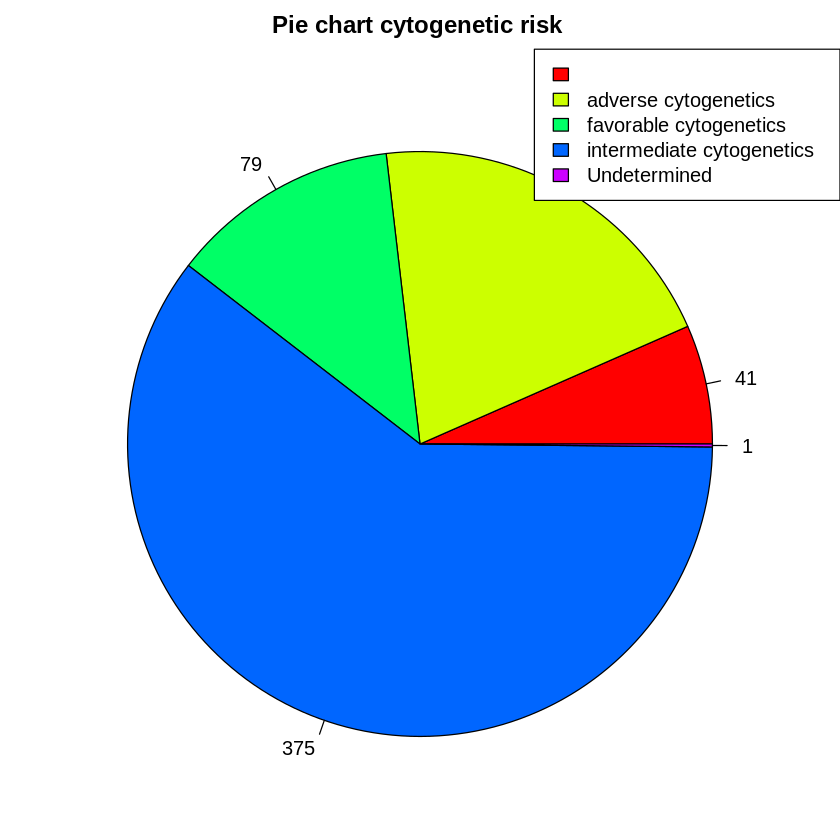

In [5]:

# count table
count_cytogenetic_risk = count(t_data_API,"cytogenetic_risk " )

# Pie chart
par(xpd=TRUE, mar=c(0,0,2,0))
pie(count_cytogenetic_risk$freq, main = "Pie chart cytogenetic risk ",labels = count_cytogenetic_risk$freq, col = rainbow(length(count_cytogenetic_risk$freq)))
legend("topright",legend = count_cytogenetic_risk$cytogenetic_risk, cex = 1,ncol = 1,
       fill = rainbow(length(count_cytogenetic_risk$freq)),xpd=NA)


### Cytogenetic subgroup

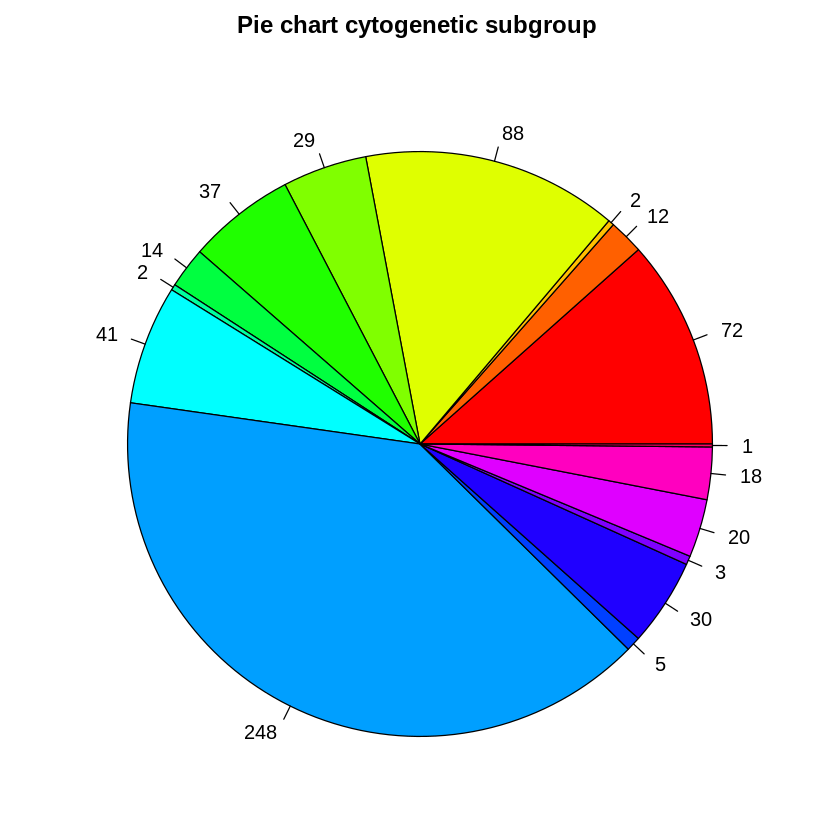

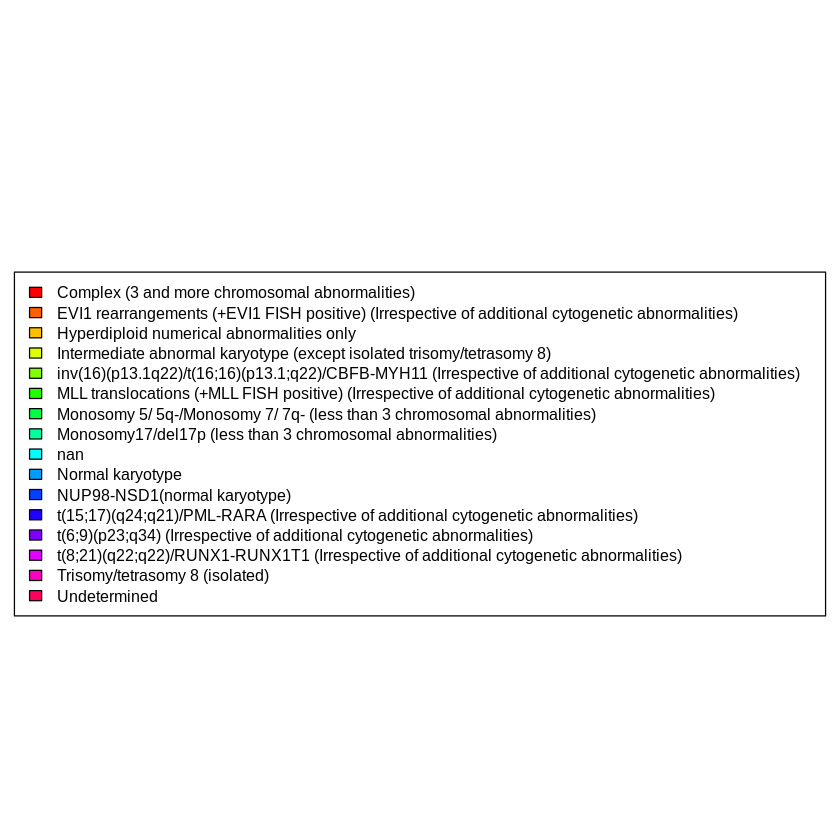

In [5]:
# count table
count_cytogenetic_subgroup = count(t_data_API, "cytogenetic_subgroup")

# Pie chart
par(xpd=TRUE, mar=c(0,0,2,0))
pie(count_cytogenetic_subgroup$freq, main = "Pie chart cytogenetic subgroup ",labels = count_cytogenetic_subgroup$freq, col = rainbow(length(count_cytogenetic_subgroup$freq)))

plot(1,type="n",axes=FALSE,xlab="",ylab="")
legend("center",legend = count_cytogenetic_subgroup$cytogenetic_subgroup, cex = 0.8,ncol = 1,
       fill = rainbow(length(count_cytogenetic_subgroup$freq)),xpd=NA)


### Subgroup

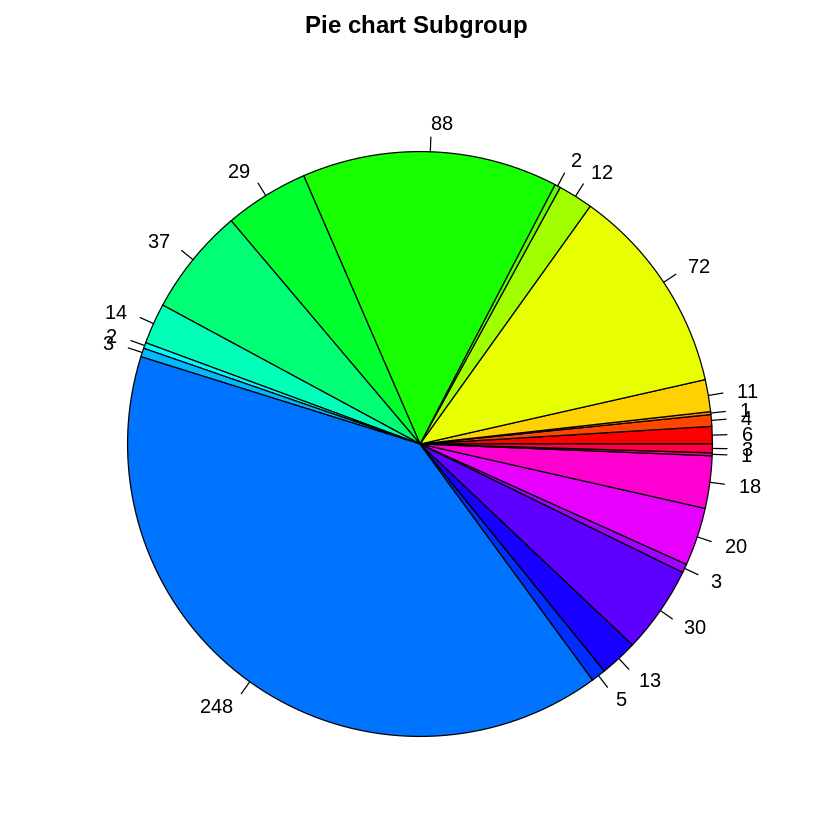

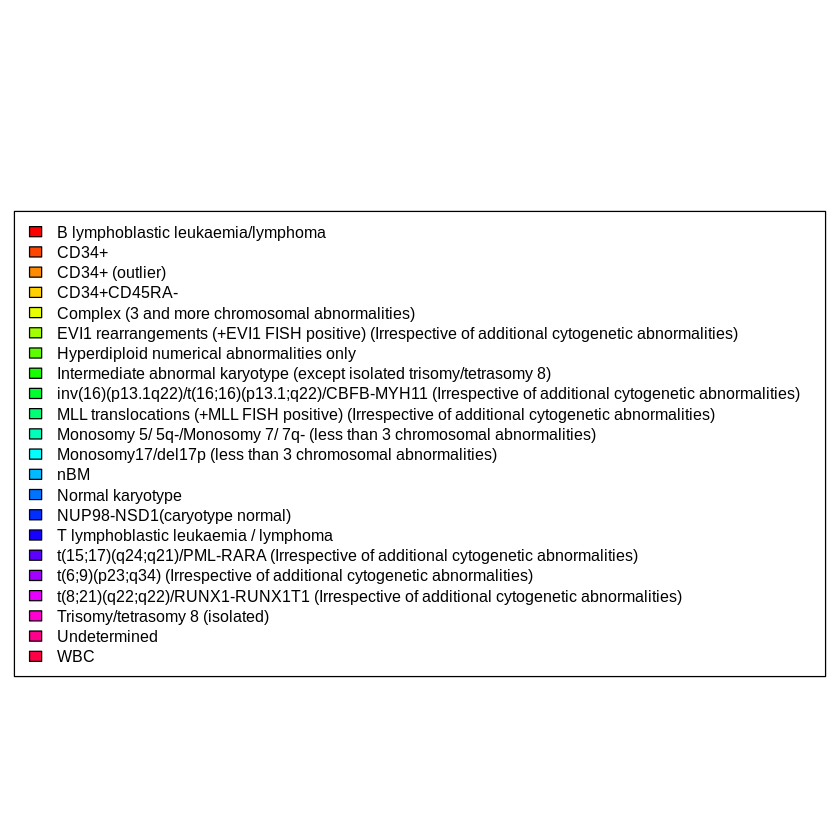

In [6]:
# count table
count_Subgroup = count(t_data_API, "Subgroup")

# Pie chart
par(xpd=TRUE, mar=c(0,0,2,0))
pie(count_Subgroup$freq, main = "Pie chart Subgroup ",labels = count_Subgroup$freq, col = rainbow(length(count_Subgroup$freq)))

plot(1,type="n",axes=FALSE,xlab="",ylab="")
legend("center",legend = count_Subgroup$Subgroup, cex = 0.8,ncol = 1,
       fill = rainbow(length(count_Subgroup$freq)),xpd=NA)

### WHO 2008

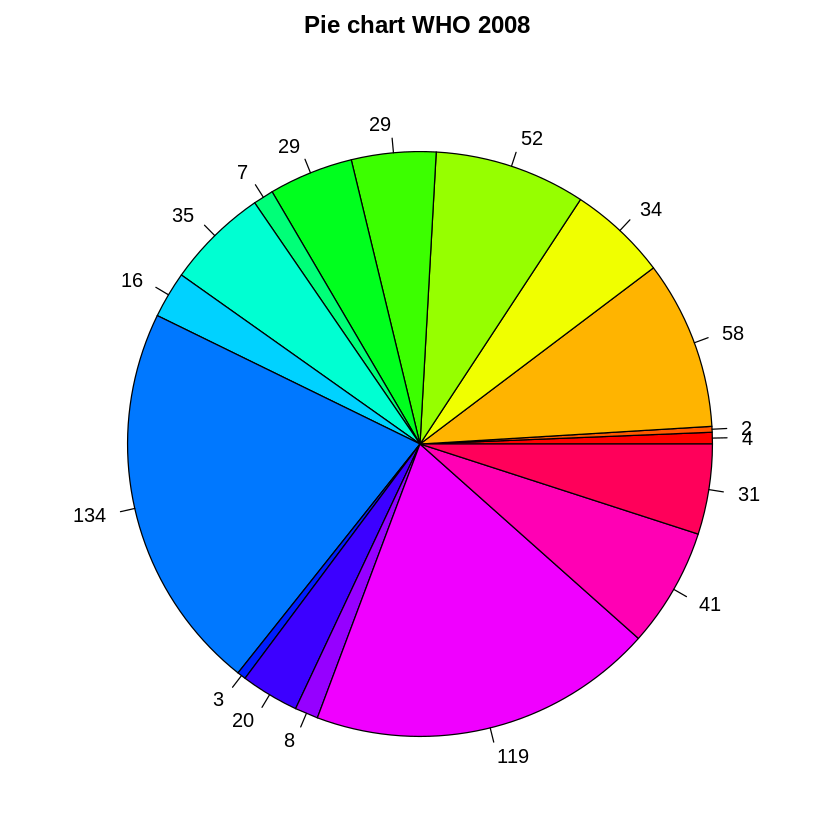

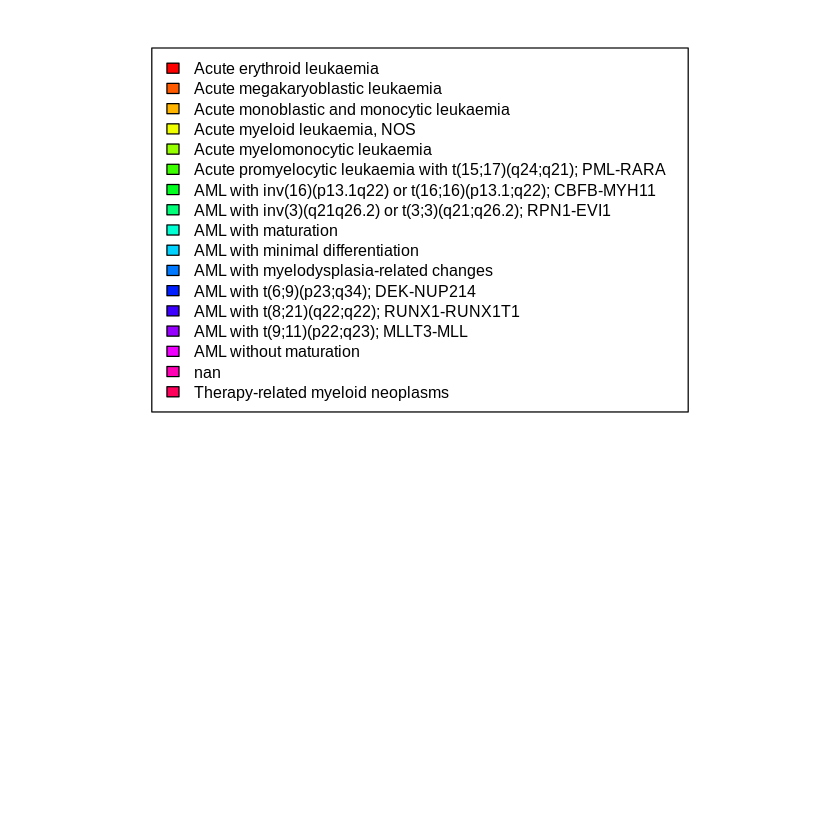

In [7]:
# count table
count_Who = count(t_data_API, "WHO_2008")

# Pie chart
par(xpd=TRUE, mar=c(0,0,2,0))
pie(count_Who$freq, main = "Pie chart WHO 2008 ",labels = count_Who$freq, col = rainbow(length(count_Who$freq)))
plot(1,type="n",axes=FALSE,xlab="",ylab="")
legend("top",legend = count_Who$WHO_2008, cex = 0.8,ncol = 1,
       fill = rainbow(length(count_Who$freq)),xpd=NA)


### FAB

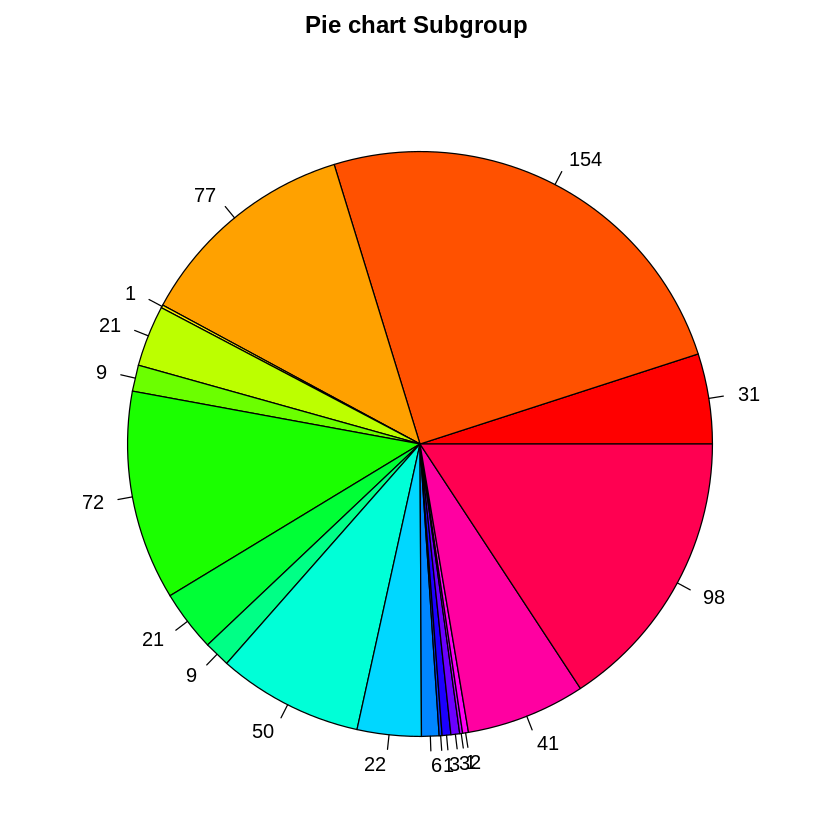

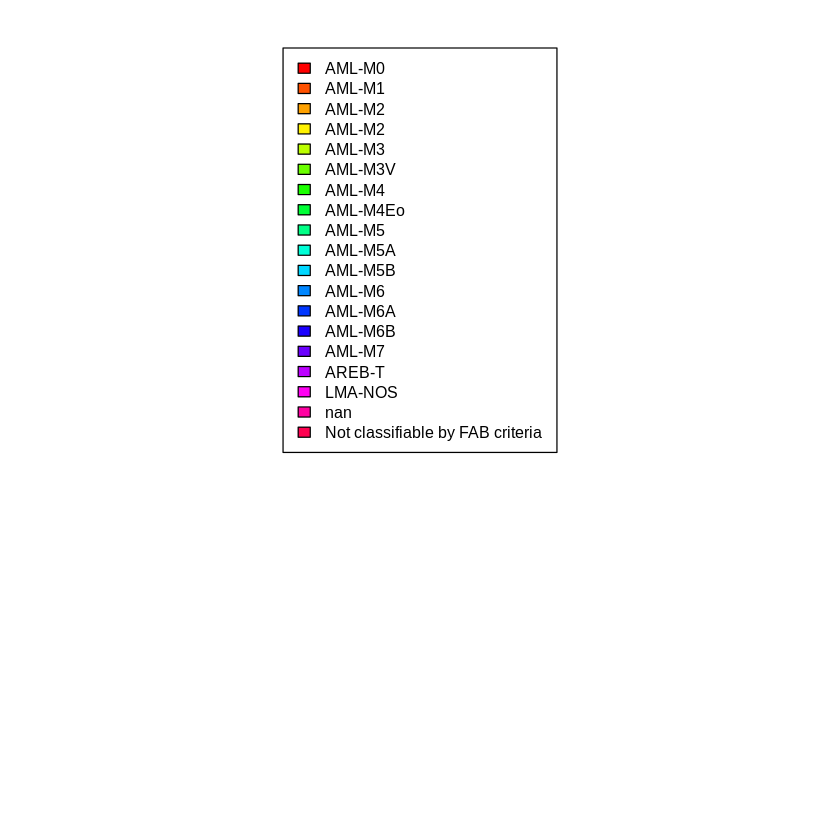

In [8]:
# count table
count_FAB = count(t_data_API, "dx_FAB")

# Pie chart
par(xpd=TRUE, mar=c(0,0,2,0))
pie(count_FAB$freq, main = "Pie chart Subgroup ",labels = count_FAB$freq, col = rainbow(length(count_FAB$freq)))
plot(1,type="n",axes=FALSE,xlab="",ylab="")
legend("top",legend = count_FAB$dx_FAB, cex = 0.8,ncol = 1,
       fill = rainbow(length(count_FAB$freq)),xpd=NA)


## % Blast

[1] 402

Warning message in hist(as.numeric(unfactor(t_data_API$`blasts_(%)`)), xlab = "blast (%)", :
“NAs introduced by coercion”

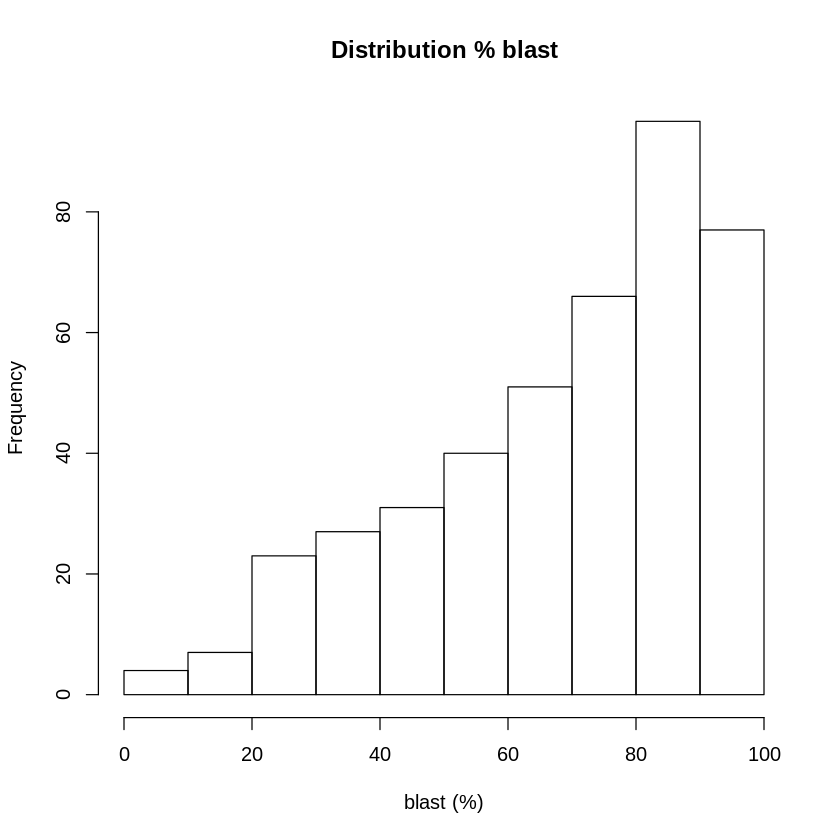

In [9]:
blast_sup_50 = row.names(t_data_API[which(unfactor(t_data_API$`blasts_(%)`)>50),])
#blast_sup_50 # Individus sequence avec un pourcentage de blast > 50 %
length(blast_sup_50) # Nombre d'individus sequence avec un pourcentage de blast > 50 %
hist(as.numeric(unfactor(t_data_API$`blasts_(%)`)),xlab = "blast (%)", main = "Distribution % blast")


## Analyse expression differentielle a partir des read count

In [10]:
adverse = row.names(t_data_API[which(unfactor(t_data_API$cytogenetic_risk)=="adverse cytogenetics"),])

intermediate = row.names(t_data_API[which(unfactor(t_data_API$cytogenetic_risk)=="intermediate cytogenetics"),])

favorable = row.names(t_data_API[which(unfactor(t_data_API$cytogenetic_risk)=="favorable cytogenetics"),])


In [11]:
read_count = read.table("/home/safia/Documents/AYA/genes_readcount.annotated.xls", header = T, sep="\t")

read_count<- data.frame(read_count[,-1], row.names=read_count[,1])
read_count = read_count[-c(1:4),]
read_count = read_count[,-c(582:585)]
names(read_count) = substring(names(read_count),8)


In [12]:
adverse = substring(adverse,2)
count_adverse = read_count[,adverse]

colnames(count_adverse) = paste("Adv", colnames(count_adverse), sep = "_")


In [13]:
intermediate = substring(intermediate,2)
count_intermediate = read_count[,intermediate]

colnames(count_intermediate) = paste("Int", colnames(count_intermediate), sep = "_")


In [14]:
favorable = substring(favorable,2)
count_favorable = read_count[,favorable]

colnames(count_favorable) = paste("Fav", colnames(count_favorable), sep = "_")


In [15]:
df = cbind(count_adverse,count_intermediate,count_favorable)

df_AI = cbind(count_adverse,count_intermediate)
df_AF = cbind(count_adverse,count_favorable)
df_IF = cbind(count_intermediate,count_favorable)

In [16]:
samples <- data.frame(groups = substr(colnames(df), 1, 3))

samples_AI <- data.frame(groups = substr(colnames(df_AI), 1, 3))
samples_AF <- data.frame(groups = substr(colnames(df_AF), 1, 3))
samples_IF <- data.frame(groups = substr(colnames(df_IF), 1, 3))

"base mean" (an average of the normalized mean counts per group), 
the log2 fold change between the groups, and the 
P-values (both "raw" and adjusted for multiple comparisons)

In [17]:
ds <- DESeqDataSetFromMatrix(countData=df, colData=samples, design=~groups)
colnames(ds) <- colnames(counts)
ds <-DESeq(ds)
res <- results(ds)
head(res)

estimating size factors
estimating dispersions
gene-wise dispersion estimates
mean-dispersion relationship
final dispersion estimates
fitting model and testing
-- replacing outliers and refitting for 4393 genes
-- DESeq argument 'minReplicatesForReplace' = 7 
-- original counts are preserved in counts(dds)
estimating dispersions
fitting model and testing


log2 fold change (MLE): groups Int vs Adv 
Wald test p-value: groups Int vs Adv 
DataFrame with 6 rows and 6 columns
                           baseMean     log2FoldChange              lfcSE
                          <numeric>          <numeric>          <numeric>
ENSG00000223972.5  6.09002764659604  -1.13190128619525   0.15486393505103
ENSG00000227232.5  285.351198943538  0.315300765503667 0.0616992142422079
ENSG00000278267.1  18.6248463910603 -0.229546947611584 0.0811231362113446
ENSG00000243485.3  11.2409443348087 -0.365607657686481  0.127866819251648
ENSG00000274890.1                 0                 NA                 NA
ENSG00000237613.2 0.101221523341385 -0.376046459986776  0.827979258023824
                                stat               pvalue                 padj
                           <numeric>            <numeric>            <numeric>
ENSG00000223972.5   -7.3090050683671 2.69127619862591e-13 1.12182797183566e-11
ENSG00000227232.5   5.11028818399396 3.21667769040262e

In [ ]:
library("tidyr")

In [18]:
res <- results(ds, tidy=TRUE) %>%
  arrange(padj, pvalue) %>%
  tbl_df()
res

goi <- res$row[1:9]
stopifnot(all(goi %in% names(ds)))
goi

tcounts <- t(log2((counts(ds[goi, ], normalized=TRUE, replaced=FALSE)+.5))) %>%
  merge(colData(ds), ., by="row.names") %>%
  gather(gene, expression, (ncol(.)-length(goi)+1):ncol(.))

tcounts %>% 
  select(Row.names, groups, gene, expression) %>% 
  head %>% 
  knitr::kable()




ggplot(tcounts, aes(groups, expression, fill=groups)) + 
  geom_boxplot() + 
  facet_wrap(~gene, scales="free_y") + 
  labs(x="Cytogenetic risk", 
       y="Expression (log normalized counts)", 
       fill="Cytogenetic risk", 
       title="Top 9 Results")


ERROR: Error in tbl_df(.): could not find function "tbl_df"


In [ ]:
ds_AI <- DESeqDataSetFromMatrix(countData=df_AI, colData=samples_AI, design=~groups)
colnames(ds_AI) <- colnames(counts)
ds_AI <-DESeq(ds_AI)
res_AI <- results(ds_AI)
head(res_AI)

In [ ]:
ds_AF<- DESeqDataSetFromMatrix(countData=df_AF, colData=samples_AF, design=~groups)
colnames(ds_AF) <- colnames(counts)
ds_AF <-DESeq(ds_AF)
res_AF <- results(ds_AF)
head(res_AF)

In [ ]:
ds_IF <- DESeqDataSetFromMatrix(countData=df_IF, colData=samples_IF, design=~groups)
colnames(ds_IF) <- colnames(counts)
ds_IF <-DESeq(ds_IF)
res_IF <- results(ds_IF)
head(res_IF)

In [ ]:
write.table(res, "res_DE_AFI.xls", sep="\t") 
write.table(res_AI, "res_DE_AI.xls", sep="\t") 
write.table(res_AF, "res_DE_AF.xls", sep="\t") 
write.table(res_IF, "res_DE_FI.xls", sep="\t") 


#### Diagramm Venn

In [ ]:
res_AI = read.table("res_DE_AI.xls", sep="\t")

res_AF = read.table("res_DE_AF.xls", sep="\t")

res_FI = read.table("res_DE_FI.xls", sep="\t")

res_AFI = read.table("res_DE_AFI.xls", sep="\t")

In [ ]:
THRESHOLD <- 0.05
res_AI.sig <- subset(res_AI, padj<THRESHOLD) 
res_AF.sig <- subset(res_AF, padj<THRESHOLD)  
res_FI.sig <- subset(res_FI, padj<THRESHOLD) 
res_AFI.sig <- subset(res_AFI, padj<THRESHOLD)



In [ ]:
print(length(rownames(res_AI.sig)))
print(length(rownames(res_AF.sig)))
print(length(rownames(res_FI.sig)))
print(length(rownames(res_AFI.sig)))

In [ ]:
library(VennDiagram)

venn.plot <- venn.diagram(list(rownames(res_AI.sig), rownames(res_AF.sig), rownames(res_FI.sig), rownames(res_AFI.sig)), NULL, fill=c("red", "green","blue","yellow"), alpha=c(0.5,0.5,0.5,0.5), cex = 2, cat.fontface=4, category.names=c("Adverse vs Intermediate", "Adverse vs Favorable","Favorable vs Intermediate","Adverse vs Favorable vs Intermediate"))
grid.draw(venn.plot)


### SOUS GROUPE ADVERSE

In [6]:
adverse = row.names(t_data_API[which(unfactor(t_data_API$cytogenetic_risk)=="adverse cytogenetics"),])

In [7]:
API_Adv = t_data_API[adverse,]

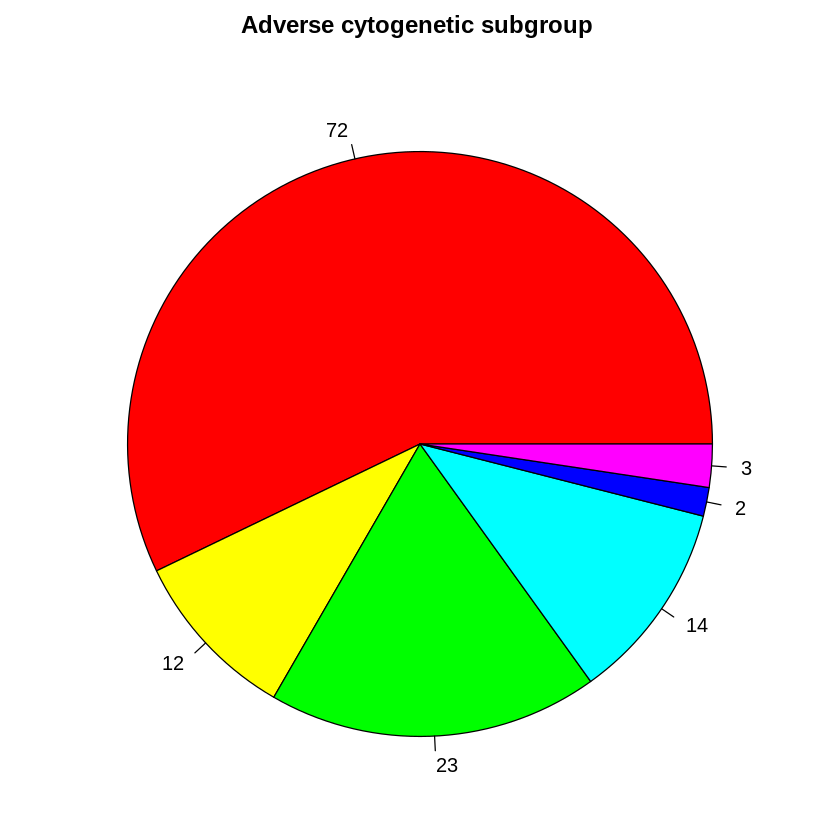

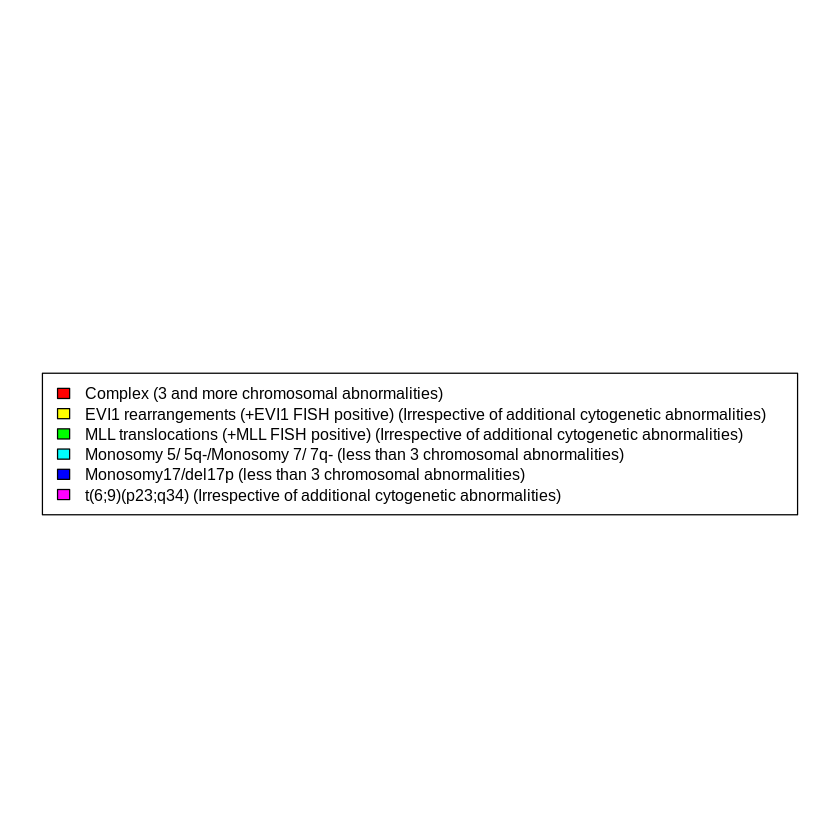

In [9]:
# count table
count_Adv_subgroup = count(API_Adv, "cytogenetic_subgroup")

# Pie chart

par(xpd=TRUE, mar=c(0,0,2,0))
pie(count_Adv_subgroup$freq, main = "Adverse cytogenetic subgroup ",labels = count_Adv_subgroup$freq, col = rainbow(length(count_Adv_subgroup$freq)))

plot(1,type="n",axes=FALSE,xlab="",ylab="")
legend("center",legend = count_Adv_subgroup$cytogenetic_subgroup, cex = 0.8,ncol = 1,
       fill = rainbow(length(count_Adv_subgroup$freq)),xpd=NA)



In [10]:
count_Adv_subgroup$cytogenetic_subgroup

X02H026 
                                                  Complex (3 and more chromosomal abnormalities) 
                                                                                         X04H050 
EVI1 rearrangements (+EVI1 FISH positive) (Irrespective of additional cytogenetic abnormalities) 
                                                                                         X01H001 
  MLL translocations (+MLL FISH positive) (Irrespective of additional cytogenetic abnormalities) 
                                                                                         X03H036 
                         Monosomy 5/ 5q-/Monosomy 7/ 7q- (less than 3 chromosomal abnormalities) 
                                                                                         X09H046 
                                       Monosomy17/del17p (less than 3 chromosomal abnormalities) 
                                                                                         X04H054 
                          t(6;9)(p23;q34) (Irrespective of additional cytogenetic abnormalities) 
16 Levels: Complex (3 and more chromosomal abnormalities) ...

In [11]:
complex = row.names(API_Adv[which(unfactor(API_Adv$cytogenetic_subgroup)==count_Adv_subgroup$cytogenetic_subgroup[1]),])

mll = row.names(API_Adv[which(unfactor(API_Adv$cytogenetic_subgroup)==count_Adv_subgroup$cytogenetic_subgroup[3]),])

m5_m7 = row.names(API_Adv[which(unfactor(API_Adv$cytogenetic_subgroup)==count_Adv_subgroup$cytogenetic_subgroup[4]),])

m17 = row.names(API_Adv[which(unfactor(API_Adv$cytogenetic_subgroup)==count_Adv_subgroup$cytogenetic_subgroup[5]),])

t6_9 = row.names(API_Adv[which(unfactor(API_Adv$cytogenetic_subgroup)==count_Adv_subgroup$cytogenetic_subgroup[6]),])

### Classification groupe complexe

In [21]:
read_count = read.table("/home/safia/Documents/AYA/genes_readcount.annotated.xls", header = T, sep="\t")

read_count<- data.frame(read_count[,-1], row.names=read_count[,1])
read_count = read_count[-c(1:4),]
read_count = read_count[,-c(582:585)]
names(read_count) = substring(names(read_count),8)


In [16]:
complex = substring(complex,2)
count_complex = read_count[,complex]


In [23]:
cohort_IQR = apply(count_complex,1,IQR)
head(cohort_IQR)

ENSG00000223972.5 ENSG00000227232.5 ENSG00000278267.1 ENSG00000243485.3 
             5.00            119.50             10.00             11.25 
ENSG00000274890.1 ENSG00000237613.2 
             0.00              0.00

In [24]:
rank_cohort_IQR = rank(cohort_IQR)
head(rank_cohort_IQR)

ENSG00000223972.5 ENSG00000227232.5 ENSG00000278267.1 ENSG00000243485.3 
          34955.5           47188.5           38569.0           39175.0 
ENSG00000274890.1 ENSG00000237613.2 
          11769.5           11769.5

In [25]:
ordered_IQR=rank_cohort_IQR[order(-rank_cohort_IQR)]
head(ordered_IQR)

ENSG00000244734.3  ENSG00000090382.6 ENSG00000156508.17  ENSG00000198804.2 
             60554              60553              60552              60551 
 ENSG00000122862.4  ENSG00000005381.7 
             60550              60549

In [26]:
ordered_data=count_complex [order(-rank_cohort_IQR),]
head(ordered_data)

,02H026,03H022,03H028,03H030,03H090,03H094,04H017,04H101,04H115,04H127,⋯,12H117,12H138,12H149,12H170,13H006,13H018,13H056,13H107,13H141,13H150
ENSG00000244734.3,3629568,138762,216674,139291,11931,12964,3147996,27328,715452,93334,⋯,1207796,1151914,680554,9603846,76616,171900,2254372,37844,44083,44186
ENSG00000090382.6,954998,481218,14784,51520,3479,10374,90258,324197,108540,97531,⋯,5639,479388,2069,113633,647625,927100,27249,253009,1000048,22518
ENSG00000156508.17,998650,376944,626153,811255,1530774,471293,347031,343786,475185,1037652,⋯,709461,853758,1257654,453313,379668,553849,551655,775886,1281361,921364
ENSG00000198804.2,1286373,535136,2439452,1581642,1006578,1699409,679763,935578,861307,564003,⋯,492850,1000278,871646,653415,814220,745406,202531,292001,1391803,930846
ENSG00000122862.4,712955,185401,33874,79031,5819,108744,453244,528820,212456,60060,⋯,14733,443620,15668,58652,649882,228497,38896,53898,248819,66160
ENSG00000005381.7,112758,87046,34508,39389,913,29038,317387,86620,8631,5102,⋯,5435,504138,3706,26576,96072,185005,28959,1470,723768,37908


In [37]:
tordered_data=t(ordered_data)
dim(tordered_data[,c(1:500)])

[1]  72 500

In [38]:
sample_dist=dist(tordered_data[,c(1:500)], method = "euclidean")

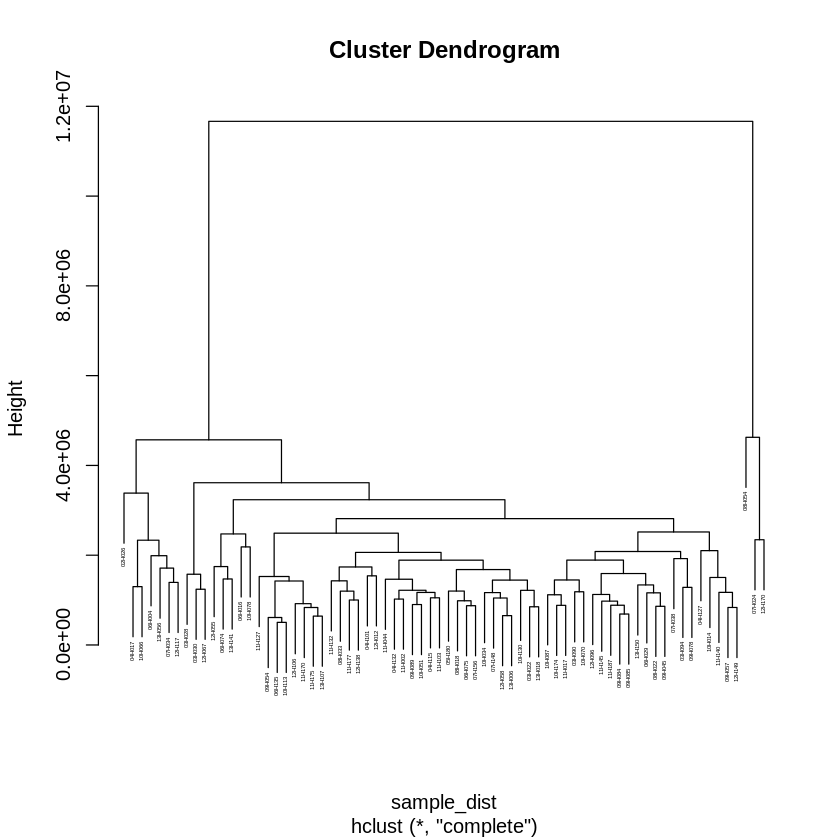

In [39]:
hc=hclust(sample_dist, method = "complete", members = NULL)

plot(hc, cex=0.3)

### information mutation p53

In [40]:
tp53_mutations = read.table("/home/safia/Documents/tp53_mutations.txt", header = T, sep="\t")

In [66]:
tp53 = colnames(tp53_mutations[2:171])
head(tp53)
tp53 = substring(tp53,2)


[1] "X01H002" "X02H017" "X02H025" "X02H026" "X02H046" "X02H053"

In [67]:
count_tp53 = read_count[,tp53]

In [89]:
?dist

dist {stats},R Documentation
x,"a numeric matrix, data frame or ""dist"" object."
method,"the distance measure to be used. This must be one of ""euclidean"", ""maximum"", ""manhattan"", ""canberra"", ""binary"" or ""minkowski"". Any unambiguous substring can be given."
diag,logical value indicating whether the diagonal of the distance matrix should be printed by print.dist.
upper,logical value indicating whether the upper triangle of the distance matrix should be printed by print.dist.
p,The power of the Minkowski distance.
m,"An object with distance information to be converted to a ""dist"" object. For the default method, a ""dist"" object, or a matrix (of distances) or an object which can be coerced to such a matrix using as.matrix(). (Only the lower triangle of the matrix is used, the rest is ignored)."
"digits, justify",passed to format inside of print().
"right, ...","further arguments, passed to other methods."
Size,"integer, the number of observations in the dataset."
Labels,"optionally, contains the labels, if any, of the observations of the dataset."


In [90]:
tp53_complex = cbind(count_complex,count_tp53)
cohort_IQR = apply(tp53_complex,1,IQR)
rank_cohort_IQR = rank(cohort_IQR)
ordered_IQR=rank_cohort_IQR[order(-rank_cohort_IQR)]
tordered_data=t(ordered_data)
sample_dist=dist(tordered_data[,c(1:1000)], method = "euclidean")
hc=hclust(sample_dist, method = "complete", members = NULL)

In [ ]:
install.packages("dendextend")
library(dendextend)

In [92]:
dend <- as.dendrogram(hc)
# Here is a second way for doing the same thing:
dend2 <- color_labels(dend, col = ifelse(labels(hc) %in% tp53, 2, 1)) 

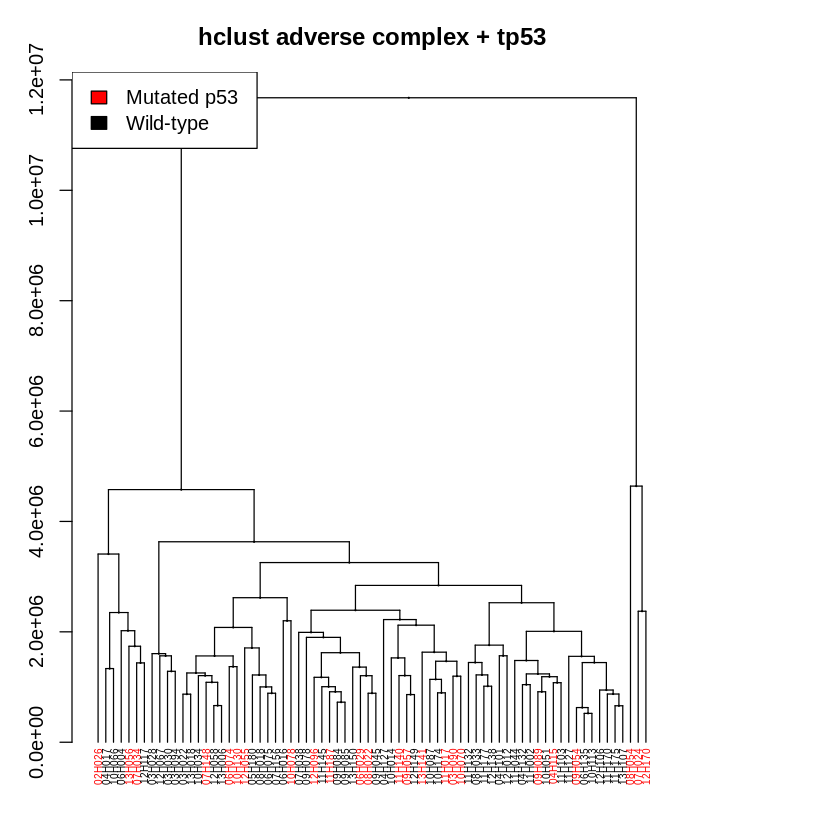

In [93]:

par(mar = c(3,3,3,7))
dend2 %>%   set("labels_cex", 0.5) %>% # Change size
  plot(main = "hclust adverse complex + tp53", 
       nodePar = list(cex = .007)) # plot
legend("topleft", legend = c("Mutated p53","Wild-type"), fill = c("red","black"))

In [ ]:
library(ggplot2)
library(ggdendro)

dm <- hclust(dist(USArrests[1:5,]), "ave")

df <- data.frame(State = c("Alabama","Alaska","Arizona","Arkansas","California"),
                 Location = c("South","North","West","South","West"))


hcdata<- dendro_data(hc, type="rectangle")

hcdata$labels <- merge(x = hcdata$labels, y = df,  by.x = "label", by.y = "State")


ggplot() +
 geom_segment(data=segment(hcdata), aes(x=x, y=y, xend=xend, yend=yend)) +
 geom_text(data = label(hcdata), aes(x=x, y=y, label=label, colour = Location, hjust=0), size=3) +
 geom_point(data = label(hcdata), aes(x=x, y=y), size=3, shape = 21) +
 coord_flip() +
 scale_y_reverse(expand=c(0.2, 0)) +
 scale_colour_brewer(palette = "Dark2") + 
 theme_dendro() 

#### Differential analysis

In [ ]:
read_count = read.table("/home/safia/Documents/AYA/genes_readcount.annotated.xls", header = T, sep="\t")
read_count<- data.frame(read_count[,-1], row.names=read_count[,1])
read_count = read_count[-c(1:4),]
read_count = read_count[,-c(582:585)]
names(read_count) = substring(names(read_count),8)


adverse = substring(adverse,2)
count_adverse = read_count[,adverse]
colnames(count_adverse) = paste("Adv", colnames(count_adverse), sep = "_")


intermediate = substring(intermediate,2)
count_intermediate = read_count[,intermediate]
colnames(count_intermediate) = paste("Int", colnames(count_intermediate), sep = "_")


favorable = substring(favorable,2)
count_favorable = read_count[,favorable]
colnames(count_favorable) = paste("Fav", colnames(count_favorable), sep = "_")


df = cbind(count_adverse,count_intermediate,count_favorable)



samples <- data.frame(groups = substr(colnames(df), 1, 3))


ds <- DESeqDataSetFromMatrix(countData=df, colData=samples, design=~groups)
colnames(ds) <- colnames(counts)
ds <-DESeq(ds)
res <- results(ds)
head(res)

write.table(res, "res_DE_AFI.xls", sep="\t") 